In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import yfinance as yf
import seaborn as sns
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
pd.options.mode.chained_assignment = None
import tensorflow as tf
tf.random.set_seed(0)

In [15]:
# Helper to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  #plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)

In [16]:
epochs = 20
ticker = "MSFT"
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)
per = "1y"

## Recurrant Neural Networks

The RNN type of network and its uses mirror that of a CNN - while the convolutional neural networks excel at capturing spatial relationships in data, RNNs excel at capturing temporal relationships, or things that change over time. This leads to this type of network to be well suited to time series types of problems, and also things like text processing, where the words that occur earlier in a sentence are connected to those that occur later. 

![RNN](images/rnn.png "RNN" )

The unique part of RNNs is that they can loop back, thus allowing the model to draw connections from things that happened in the past. 

### Long Short Term Memory

Long Short Term Memory (lstm) models are a type of RNN that we can commonly use to make time series predictions. LSTM models function to "remember" certain data and carry that forward, and forget other data. 

![LSTM](images/lstm.png "LSTM" )



### Past Model

We can generate some predictions and see what type of accuracy we can get. 

##### Load Data

We will load the close price of a stock, scale it, and preview the first 5 prices to make sure we're good. 

In [17]:
# download the data
df = yf.download(tickers=[ticker], period=per)
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)
print(y[:5])

[*********************100%***********************]  1 of 1 completed
[[0.0967247 ]
 [0.08510231]
 [0.10469691]
 [0.13687448]
 [0.16184813]]


##### Generate Data for Predictions

For each point in our data we generate additional data at that point. 

The outcome of this will be data where each time point is now no longer just 1 value, like a normal time series, but it is a bunch of dates - this  is the "long term" memory part. The X's shape is:
<ul>
<li> (# of rows of data, # of lookback rows, number of features)
<li> I.e. each "row" now has the past 60 values as part of it. 
</ul>

The Y's shape is:
<ul>
<li> (# of rows of data, # of forecasting rows, number of features)
<li> I.e. each row is a prediction into the future. 
</ul>

Each of the inputs for our data "remembers" the past 60 days into the past! This is what allows these models to do such a good job on sequential data. 

In [18]:
# generate the input and output sequences
X = []
Y = []

for i in range(n_lookback, len(y)):
    X.append(y[i - n_lookback: i])
    y_tmp = y[i: i + n_forecast]
    Y.append(y_tmp[0][0])

X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)

(195, 60, 1) (195,)


##### Fit Models

We can now make a model and train it. The long-short term memory layers are mostly simple to use, we need to be aware of a few things:
<ul>
<li> Input shape - this input shape is the size of the previous records and the number of features. Here we have 60 for the n_lookback and 1 for the number of features. 
<li> Return Sequences - 
<li> Output - each forecast gets its own output neuron. 
</ul>

In [19]:
# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X, Y, epochs=epochs, batch_size=32, verbose=1)
tmp = model.predict(X)

Epoch 1/20
7/7 [==============================] - 3s 32ms/step - loss: 0.4054
Epoch 2/20
7/7 [==============================] - 0s 27ms/step - loss: 0.2507
Epoch 3/20
7/7 [==============================] - 0s 32ms/step - loss: 0.0915
Epoch 4/20
7/7 [==============================] - 0s 38ms/step - loss: 0.0399
Epoch 5/20
7/7 [==============================] - 0s 36ms/step - loss: 0.0254
Epoch 6/20
7/7 [==============================] - 0s 28ms/step - loss: 0.0224
Epoch 7/20
7/7 [==============================] - 0s 36ms/step - loss: 0.0197
Epoch 8/20
7/7 [==============================] - 0s 32ms/step - loss: 0.0192
Epoch 9/20
7/7 [==============================] - 0s 27ms/step - loss: 0.0172
Epoch 10/20
7/7 [==============================] - 0s 26ms/step - loss: 0.0144
Epoch 11/20
7/7 [==============================] - 0s 27ms/step - loss: 0.0130
Epoch 12/20
7/7 [==============================] - 0s 25ms/step - loss: 0.0131
Epoch 13/20
7/7 [==============================] - 0s 28ms/st

##### Print Results



<AxesSubplot:title={'center':'MSFT'}, xlabel='Date'>

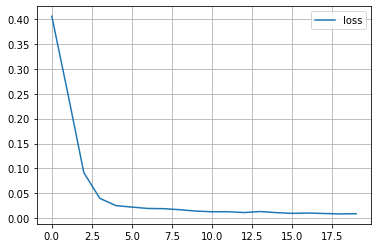

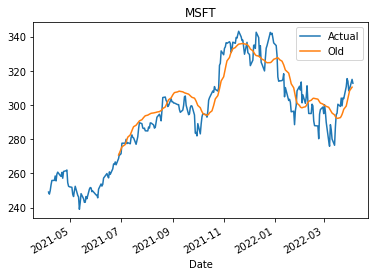

In [20]:
# Print
old_preds = []
for i in range(len(tmp)):
    old_preds.append(tmp[i][0])
#for i in range(len(tmp[-1])):
#    old_preds.append(tmp[-1][i])

# organize the results in a data frame
df_past = df[['Close']].reset_index()
#print(len(df_past))
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
#df_past['Forecast'] = np.nan
#df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
df_past['Old'] = np.nan
for i in range(len(old_preds)):
    df_past["Old"].iloc[i+n_lookback-1] = scaler.inverse_transform(np.array(old_preds[i]).reshape(1,-1))

results = df_past.set_index('Date')
# plot the results
plot_loss(history)
results.plot(title=ticker)

In [21]:
df_tmp = df_past[~df_past["Old"].isna()]
trainScore = math.sqrt(mean_squared_error(df_tmp["Actual"], df_tmp["Old"]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 8.94 RMSE


### Model With Forward Predictions

We can take a model and produce forward looking predictions. 

[*********************100%***********************]  1 of 1 completed
(195, 60, 1) (195,)
Epoch 1/20
7/7 [==============================] - 3s 29ms/step - loss: 0.3941
Epoch 2/20
7/7 [==============================] - 0s 28ms/step - loss: 0.2267
Epoch 3/20
7/7 [==============================] - 0s 28ms/step - loss: 0.0983
Epoch 4/20
7/7 [==============================] - 0s 29ms/step - loss: 0.0437
Epoch 5/20
7/7 [==============================] - 0s 28ms/step - loss: 0.0281
Epoch 6/20
7/7 [==============================] - 0s 28ms/step - loss: 0.0210
Epoch 7/20
7/7 [==============================] - 0s 32ms/step - loss: 0.0183
Epoch 8/20
7/7 [==============================] - 0s 28ms/step - loss: 0.0176
Epoch 9/20
7/7 [==============================] - 0s 28ms/step - loss: 0.0170
Epoch 10/20
7/7 [==============================] - 0s 27ms/step - loss: 0.0137
Epoch 11/20
7/7 [==============================] - 0s 27ms/step - loss: 0.0131
Epoch 12/20
7/7 [==============================] - 

<AxesSubplot:title={'center':'MSFT'}, xlabel='Date'>

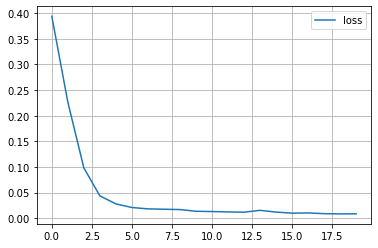

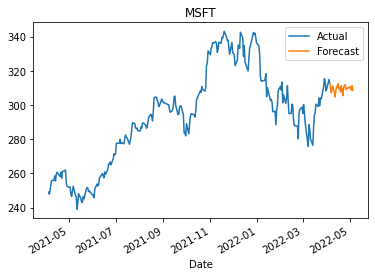

In [22]:
# download the data
df = yf.download(tickers=[ticker], period=per)
y = df['Close'].fillna(method='ffill')
y = y.values.reshape(-1, 1)
#print(y)
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
y = scaler.transform(y)
#print(y)
# generate the input and output sequences


X = []
Y = []

for i in range(n_lookback, len(y)):
    X.append(y[i - n_lookback: i])
    y_tmp = y[i: i + n_forecast]
    Y.append(y_tmp[0][0])

X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)

# fit the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X, Y, epochs=epochs, batch_size=32, verbose=1)

# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
plot_loss(history)
results.plot(title=ticker)

## Multiple Variable Regression

We can also extened time series stuff to deal with multiple varaibles as inputs. For example, for the stock prices we can include the trading volume as well. 

Here our feature set is two values - the price that we are used to with a time series, and also the volume. 

The shape of the input chages here, and this can be adapted to more elaborate prediction scenarios. The 

[*********************100%***********************]  1 of 1 completed
(255, 2)
(195, 60, 2) (195,)
Epoch 1/20
7/7 [==============================] - 3s 30ms/step - loss: 0.3690
Epoch 2/20
7/7 [==============================] - 0s 26ms/step - loss: 0.2298
Epoch 3/20
7/7 [==============================] - 0s 27ms/step - loss: 0.1328
Epoch 4/20
7/7 [==============================] - 0s 26ms/step - loss: 0.0785
Epoch 5/20
7/7 [==============================] - 0s 26ms/step - loss: 0.0476
Epoch 6/20
7/7 [==============================] - 0s 28ms/step - loss: 0.0288
Epoch 7/20
7/7 [==============================] - 0s 27ms/step - loss: 0.0209
Epoch 8/20
7/7 [==============================] - 0s 27ms/step - loss: 0.0188
Epoch 9/20
7/7 [==============================] - 0s 28ms/step - loss: 0.0169
Epoch 10/20
7/7 [==============================] - 0s 28ms/step - loss: 0.0164
Epoch 11/20
7/7 [==============================] - 0s 26ms/step - loss: 0.0133
Epoch 12/20
7/7 [=========================

/var/folders/px/vhm_920n7zx2wvqq_ht0q5tm0000gp/T/ipykernel_76877/3868511984.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tmp = np.array(list(zip(Y_,tmp_zeros)))


<AxesSubplot:title={'center':'MSFT'}, xlabel='Date'>

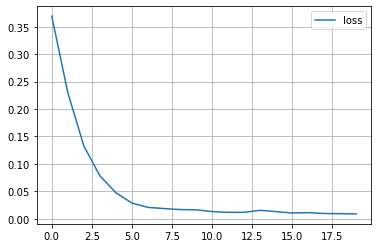

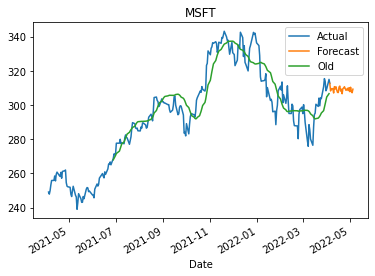

In [23]:
features = 2

# download the data
df = yf.download(tickers=[ticker], period=per)
y = df[['Close', 'Volume']].fillna(method='ffill')
#print(y)
y = y.values.reshape(-1, features)
#print(y)
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
print(y.shape)
y = scaler.transform(y)
#print(y)

X = []
Y = []

#for i in range(n_lookback, len(y) - n_forecast + 1):
for i in range(n_lookback, len(y)):
    X.append(y[i - n_lookback: i])
    y_tmp = y[i: i + n_forecast]
    Y.append(y_tmp[0][0])
#print(X)
#print(Y)
X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)

# fit the model
model = Sequential()
model.add(LSTM(units=60, return_sequences=True, input_shape=(n_lookback, features)))
#model.add(LSTM(units=30, return_sequences = True))
model.add(LSTM(units=30))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X, Y, epochs=epochs, batch_size=32, verbose=1)
tmp = model.predict(X)

# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, features)

#Accuracy
old_preds = []
for i in range(len(tmp)):
    old_preds.append(tmp[i][0])

Y_ = model.predict(X_).reshape(-1, 1)
tmp_zeros = [0] * len(Y_)
tmp = np.array(list(zip(Y_,tmp_zeros)))
tmp_dict = {"pred":Y_.flatten(), "zero":tmp_zeros}
tmp_df = pd.DataFrame.from_dict(tmp_dict)
Y_ = scaler.inverse_transform(tmp_df)
Y_ = [item[0] for item in Y_]

# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

#Old
df_past['Old'] = np.nan
tmp_zeros = [0] * len(old_preds)
tmp = np.array(list(zip(old_preds,tmp_zeros)))
tmp_dict = {"pred":old_preds, "zero":tmp_zeros}
tmp_df = pd.DataFrame.from_dict(tmp_dict)
old_ = scaler.inverse_transform(tmp_df)
old_ = [item[0] for item in old_]
for i in range(len(old_)):
    df_past["Old"].iloc[i+n_lookback-1] = old_[i]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast', 'Old'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_#.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
plot_loss(history)
results.plot(title=ticker)

In [24]:
df_tmp = df_past[~df_past["Old"].isna()]
trainScore = math.sqrt(mean_squared_error(df_tmp["Actual"], df_tmp["Old"]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 8.92 RMSE


#### Add Some Tweaks

[*********************100%***********************]  1 of 1 completed
(255, 2)
(195, 60, 2) (195,)
Epoch 1/20
7/7 [==============================] - 5s 85ms/step - loss: 0.4079
Epoch 2/20
7/7 [==============================] - 1s 72ms/step - loss: 0.2947
Epoch 3/20
7/7 [==============================] - 0s 69ms/step - loss: 0.2175
Epoch 4/20
7/7 [==============================] - 0s 67ms/step - loss: 0.1714
Epoch 5/20
7/7 [==============================] - 0s 69ms/step - loss: 0.1364
Epoch 6/20
7/7 [==============================] - 0s 68ms/step - loss: 0.1114
Epoch 7/20
7/7 [==============================] - 0s 68ms/step - loss: 0.0995
Epoch 8/20
7/7 [==============================] - 0s 69ms/step - loss: 0.0910
Epoch 9/20
7/7 [==============================] - 0s 67ms/step - loss: 0.0804
Epoch 10/20
7/7 [==============================] - 0s 68ms/step - loss: 0.0681
Epoch 11/20
7/7 [==============================] - 1s 70ms/step - loss: 0.0627
Epoch 12/20
7/7 [=========================

/var/folders/px/vhm_920n7zx2wvqq_ht0q5tm0000gp/T/ipykernel_76877/2599343724.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tmp = np.array(list(zip(Y_,tmp_zeros)))


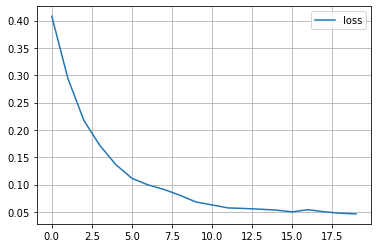

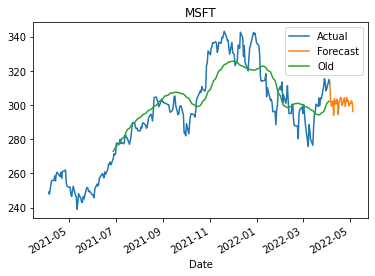

In [27]:
features = 2

# download the data
df = yf.download(tickers=[ticker], period=per)
y = df[['Close', 'Volume']].fillna(method='ffill')
#print(y)
y = y.values.reshape(-1, features)
#print(y)
# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(y)
print(y.shape)
y = scaler.transform(y)
#print(y)

X = []
Y = []

#for i in range(n_lookback, len(y) - n_forecast + 1):
for i in range(n_lookback, len(y)):
    X.append(y[i - n_lookback: i])
    y_tmp = y[i: i + n_forecast]
    Y.append(y_tmp[0][0])
#print(X)
#print(Y)
X = np.array(X)
Y = np.array(Y)
print(X.shape, Y.shape)

# fit the model
model = Sequential()
model.add(LSTM(units=60, return_sequences=True, input_shape=(n_lookback, features)))
model.add(Dropout(0.3))
model.add(LSTM(units=60, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units=60, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units=30))
model.add(Dropout(0.3))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X, Y, epochs=epochs, batch_size=32, verbose=1)
tmp = model.predict(X)

# generate the forecasts
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, features)

#Accuracy
old_preds = []
for i in range(len(tmp)):
    old_preds.append(tmp[i][0])

Y_ = model.predict(X_).reshape(-1, 1)
tmp_zeros = [0] * len(Y_)
tmp = np.array(list(zip(Y_,tmp_zeros)))
tmp_dict = {"pred":Y_.flatten(), "zero":tmp_zeros}
tmp_df = pd.DataFrame.from_dict(tmp_dict)
Y_ = scaler.inverse_transform(tmp_df)
Y_ = [item[0] for item in Y_]

# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

#Old
df_past['Old'] = np.nan
tmp_zeros = [0] * len(old_preds)
tmp = np.array(list(zip(old_preds,tmp_zeros)))
tmp_dict = {"pred":old_preds, "zero":tmp_zeros}
tmp_df = pd.DataFrame.from_dict(tmp_dict)
old_ = scaler.inverse_transform(tmp_df)
old_ = [item[0] for item in old_]
for i in range(len(old_)):
    df_past["Old"].iloc[i+n_lookback-1] = old_[i]

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast', 'Old'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_#.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
plot_loss(history)
results.plot(title=ticker)
df_tmp = df_past[~df_past["Old"].isna()]
trainScore = math.sqrt(mean_squared_error(df_tmp["Actual"], df_tmp["Old"]))
print('Train Score: %.2f RMSE' % (trainScore))